In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scienceplots
import shap
import xgboost as xgb

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import FIVE_LAYERS
from events_package.input_getters import get_Y_1, get_Y_2, get_X_5
from events_package.BinFunction import BinFunction

In [2]:
Experiment.__version__

'5.0'

# 1. Importing Single Particle Data

## 1.1 Electrons

In [3]:
# importing data
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
)

electrons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
electrons.length

444840

In [4]:
electrons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998


## 1.2 Photons

In [5]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Photon\Parquet\1m_photon_pq"
)

photons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
photons.length

444142

In [6]:
photons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870


## 1.3 Neutral Pions

In [7]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiZero\Parquet\pq_pi0_2"
)

pi0 = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi0.length

412856

In [8]:
pi0.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483


## 1.4 Charged Pions

In [9]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiPlusMinus\Parquet\pq_piplusminus_2"
)

pi_char = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi_char.length

357554

In [10]:
pi_char.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 330809


## 1.5 Combining Different Particle Data

In [11]:
# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

In [12]:
experiment = electrons + photons + pi0 + pi_char
del electrons, photons, pi0, pi_char
# all previous datasets have already been denoisified, duplicates were removed, no need to do it now
# in fact, doing it would delete some good events
experiment.shuffle_dataset(repeats=11)
print(experiment.length)

1592160


In [13]:
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)
X_train = experiment.X_train

(-0.2, 0.2)

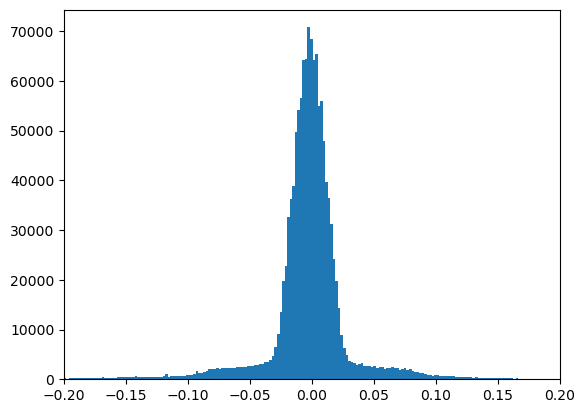

In [14]:
plt.hist(experiment.X_train.T[5], bins=1500)
plt.xlim(-0.2, 0.2)

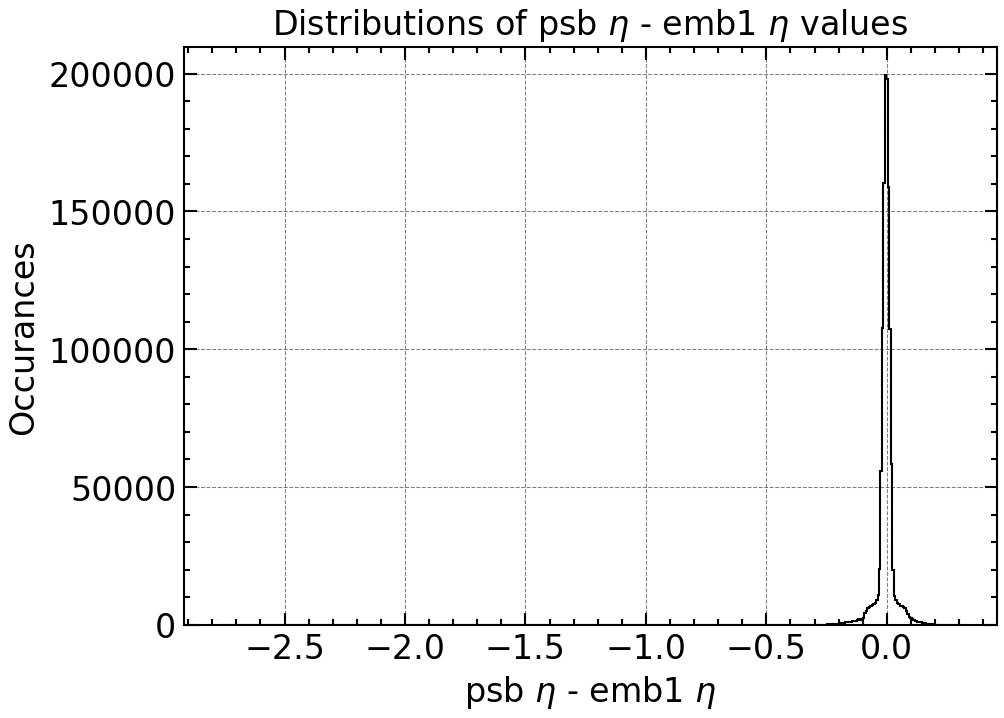

In [15]:
with plt.style.context(["science", "notebook", "grid"]):
    plt.figure(figsize=(7, 5), dpi=150)

    # histograms with common bin edges
    plt.hist(
        experiment.X_train.T[5], bins=500, density=False, histtype="step", color="k"
    )

    plt.xlabel(r"psb $\eta$ - emb1 $\eta$")
    plt.ylabel("Occurances")
    plt.title(r"Distributions of psb $\eta$ - emb1 $\eta$ values")
    plt.show()

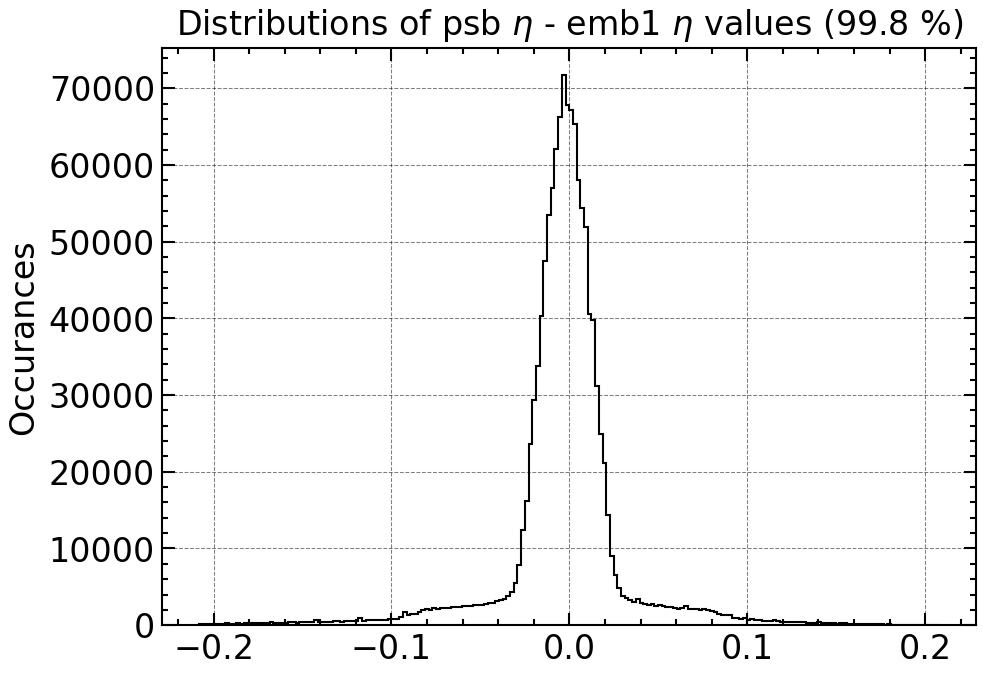

In [16]:
mask = np.abs(experiment.X_train.T[5]) < 0.208

with plt.style.context(["science", "notebook", "grid"]):
    plt.figure(figsize=(7, 5), dpi=150)

    # histograms with common bin edges
    plt.hist(
        experiment.X_train.T[5][mask],
        bins=200,
        density=False,
        histtype="step",
        color="k",
    )

    plt.xlabel("")
    plt.ylabel("Occurances")
    plt.title(r"Distributions of psb $\eta$ - emb1 $\eta$ values (99.8 %)")
    plt.show()

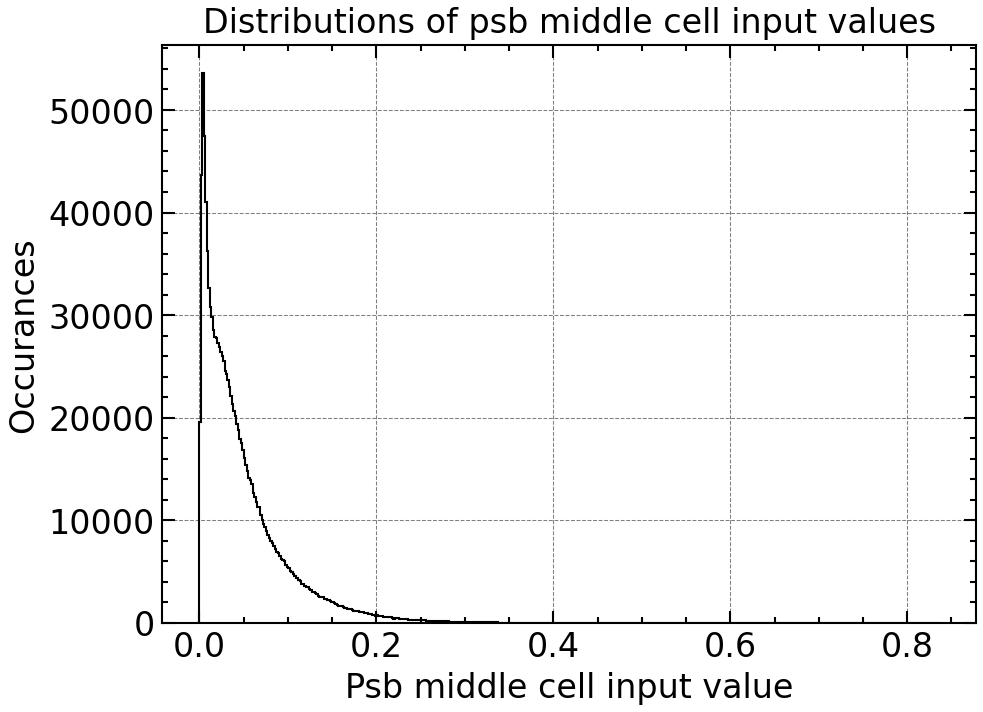

In [17]:
with plt.style.context(["science", "notebook", "grid"]):
    plt.figure(figsize=(7, 5), dpi=150)

    # histograms with common bin edges
    plt.hist(
        experiment.X_train.T[9], bins=500, density=False, histtype="step", color="k"
    )

    plt.xlabel("Psb middle cell input value")
    plt.ylabel("Occurances")
    plt.title("Distributions of psb middle cell input values")
    plt.show()

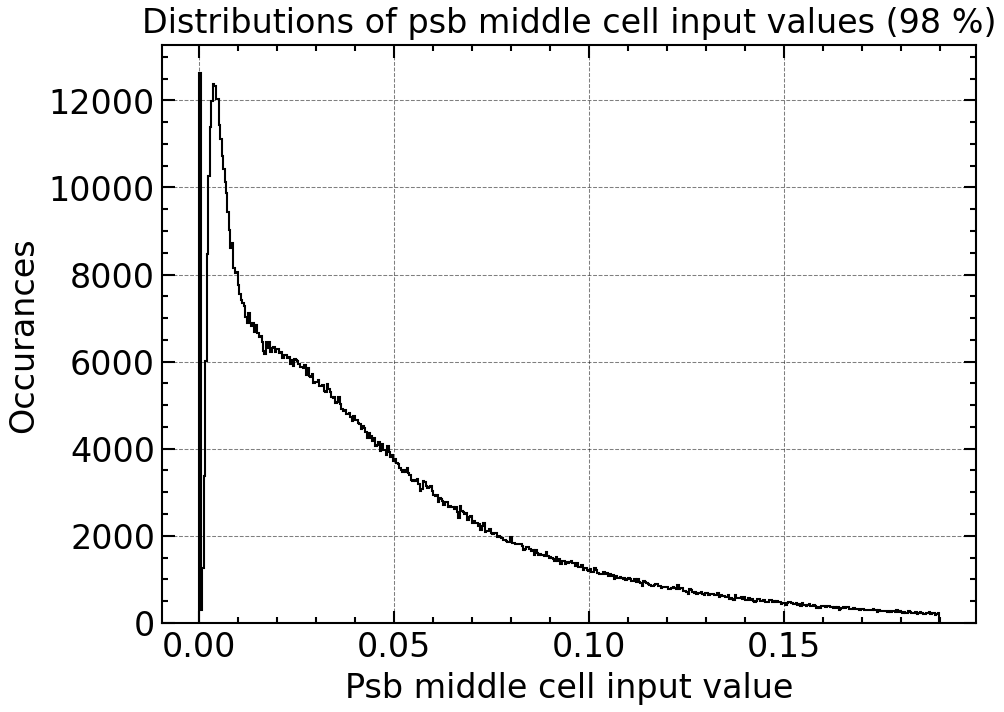

In [18]:
mask = np.abs(experiment.X_train.T[9]) < 0.18982

with plt.style.context(["science", "notebook", "grid"]):
    plt.figure(figsize=(7, 5), dpi=150)

    # histograms with common bin edges
    plt.hist(
        experiment.X_train.T[9][mask],
        bins=500,
        density=False,
        histtype="step",
        color="k",
    )

    plt.xlabel("Psb middle cell input value")
    plt.ylabel("Occurances")
    plt.title("Distributions of psb middle cell input values (98 %)")
    plt.show()

In [19]:
utils.calculate_confidence_range(experiment.X_train.T[9], cl=98)

(0, 0.1898209514324228)

In [20]:
utils.calculate_confidence_interval(experiment.X_train.T[5], cl=99.8)

0.20832844769600006

In [21]:
params1 = {
    "objective": "reg:squarederror",
    "gamma": 0,
    "max_depth": 4,
    "learning_rate": 0.74,
    # "subsample": 0.8,
    "colsample_bytree": 1.0,
    "eval_metric": "rmse",
    "n_estimators": 130,
}

experiment.train_xgboost_model(params1, normalise=False)  # 4480.9043

INFO: Trained XGBoost model; mean squared error: 4338.286543446817


4338.286543446817

In [22]:
mask_e = experiment.testing_dataset.physics_object_type == "electron"
mask_p = experiment.testing_dataset.physics_object_type == "photon"
mask_pi0 = experiment.testing_dataset.physics_object_type == "pi0"
mask_pi_char = experiment.testing_dataset.physics_object_type == "pi_char"

x_e1, y_e1, x_u_e1, u_e1 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    plot=False,
    return_x_u=True,
)

x_p1, y_p1, x_u_p1, u_p1 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_p],
    y_values=(experiment.y_test - experiment.y_pred)[mask_p],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    plot=False,
    return_values=True,
    return_x_u=True,
)

x_pi01, y_pi01, x_u_pi01, u_pi01 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi0],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi0],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    plot=False,
    return_values=True,
    return_x_u=True,
)

x_pi_char1, y_pi_char1, x_u_pi_char1, u_pi_char1 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi_char],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi_char],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    plot=False,
    return_x_u=True,
)

# Quantise

In [23]:
psb_mapping = utils.create_mapping(np.unique(np.sort(experiment.psb_eta.values)))
emb1_mapping = utils.create_mapping(np.unique(np.sort(experiment.emb1_eta.values)))
emb2_mapping = utils.create_mapping(np.unique(np.sort(experiment.emb2_eta.values)))
emb3_mapping = utils.create_mapping(np.unique(np.sort(experiment.emb3_eta.values)))
hab1_mapping = utils.create_mapping(np.unique(np.sort(experiment.hab1_eta.values)))

In [24]:
mappings = {
    "psb_mapping": psb_mapping,
    "emb1_mapping": emb1_mapping,
    "emb2_mapping": emb2_mapping,
    "emb3_mapping": emb3_mapping,
    "hab1_mapping": hab1_mapping,
}

In [25]:
current_directory = os.getcwd()
quantisations_directory = os.path.join(current_directory, "..", "quantisations")

# ensure that the "quantisations" directory exists, if not, create it
if not os.path.exists(quantisations_directory):
    os.makedirs(quantisations_directory)

# full path
pickle_path = os.path.join(quantisations_directory, "mappings.pkl")

# save the mappings dictionary to a pickle file
with open(pickle_path, "wb") as f:
    pickle.dump(mappings, f)

In [26]:
bin_q = 256

bin_functions = {}

# Loop to create and store the instances
for i in range(5, 22):  # Assuming X_train_3.T[5] to X_train_3.T[21]
    cl = 99.8
    if i in [9, 11, 16, 18, 20]:
        cl = 98

    bin_functions[f"q{i}"] = BinFunction(X_train.T[i], bins=bin_q, cl=cl)

pickle_path = os.path.join(quantisations_directory, "bin_functions.pkl")

# Save the bin_functions object to a pickle file
with open(pickle_path, "wb") as f:
    pickle.dump(bin_functions, f)

In [27]:
diff1_q = bin_functions["q5"]
diff2_q = bin_functions["q6"]
diff3_q = bin_functions["q7"]
diff4_q = bin_functions["q8"]


q9 = bin_functions["q9"]  # psb (4)
q10 = bin_functions["q10"]  # psn (5) - psb (3)
q11 = bin_functions["q11"]  # emb1 (8)
q12 = bin_functions["q12"]  # emb1 (9) - emb1 (7)
q13 = bin_functions["q13"]  # emb1(10) - emb1(6)
q14 = bin_functions["q14"]  # emb1(11) - emb1(5)
q15 = bin_functions["q15"]  # emb1(12) - emb1(4)
q16 = bin_functions["q16"]  # emb2(4)
q17 = bin_functions["q17"]  # emb2(5) - emb2(3)
q18 = bin_functions["q18"]  # emb3(4)
q19 = bin_functions["q19"]  # emb3(5) - emb3(3)
q20 = bin_functions["q20"]  # hab1(4)
q21 = bin_functions["q21"]  # hab1(5) - hab1(3)

In [28]:
def get_X_5_quant(dataframe):
    """Quantising etas and ata diffs."""

    s = dataframe.shape[0]  # number of rows (events)

    psb_info = np.sum(dataframe["psb_cells"].values.reshape(s, 7, 9), axis=1)
    emb1_info = np.sum(dataframe["emb1_cells"].values.reshape(s, 3, 17), axis=1)
    emb2_info = np.sum(dataframe["emb2_cells"].values.reshape(s, 7, 9), axis=1)
    emb3_info = np.sum(dataframe["emb3_cells"].values.reshape(s, 7, 9), axis=1)
    hab1_info = np.sum(dataframe["hab1_cells"].values.reshape(s, 7, 9), axis=1)

    psb_tot = np.sum(psb_info, axis=1)
    emb1_tot = np.sum(emb1_info, axis=1)
    emb2_tot = np.sum(emb2_info, axis=1)
    emb3_tot = np.sum(emb3_info, axis=1)
    hab1_tot = np.sum(hab1_info, axis=1)
    en_tot = psb_tot + emb1_tot + emb2_tot + emb3_tot + hab1_tot

    psb_info = utils.fold_list_2d(psb_info) / en_tot[:, np.newaxis]
    emb1_info = utils.fold_list_2d(emb1_info) / en_tot[:, np.newaxis]
    emb2_info = utils.fold_list_2d(emb2_info) / en_tot[:, np.newaxis]
    emb3_info = utils.fold_list_2d(emb3_info) / en_tot[:, np.newaxis]
    hab1_info = utils.fold_list_2d(hab1_info) / en_tot[:, np.newaxis]

    v9 = psb_info.T[0]
    v10 = psb_info.T[1]
    v11 = emb1_info.T[0]
    v12 = emb1_info.T[1]
    v13 = emb1_info.T[2]
    v14 = emb1_info.T[3]
    v15 = emb1_info.T[4]
    v16 = emb2_info.T[0]
    v17 = emb2_info.T[1]
    v18 = emb3_info.T[0]
    v19 = emb3_info.T[1]

    v20 = hab1_info.T[0]
    v21 = hab1_info.T[1]

    in9 = np.array([q9.bin_function(val) for val in v9])
    in10 = np.array([q10.bin_function(val) for val in v10])
    in11 = np.array([q11.bin_function(val) for val in v11])
    in12 = np.array([q12.bin_function(val) for val in v12])
    in13 = np.array([q13.bin_function(val) for val in v13])
    in14 = np.array([q14.bin_function(val) for val in v14])
    in15 = np.array([q15.bin_function(val) for val in v15])
    in16 = np.array([q16.bin_function(val) for val in v16])
    in17 = np.array([q17.bin_function(val) for val in v17])
    in18 = np.array([q18.bin_function(val) for val in v18])
    in19 = np.array([q19.bin_function(val) for val in v19])

    in20 = np.array([q20.bin_function(val) for val in v20])
    in21 = np.array([q21.bin_function(val) for val in v21])

    # eta mappings
    psb_eta_info = np.array([psb_mapping[val] for val in dataframe.psb_eta.values])
    emb1_eta_info = np.array([emb1_mapping[val] for val in dataframe.emb1_eta.values])
    emb2_eta_info = np.array([emb2_mapping[val] for val in dataframe.emb2_eta.values])
    emb3_eta_info = np.array([emb3_mapping[val] for val in dataframe.emb3_eta.values])
    hab1_eta_info = np.array([hab1_mapping[val] for val in dataframe.hab1_eta.values])

    diffs_exact_1 = dataframe.psb_eta.values.astype(
        "float16"
    ) - dataframe.emb1_eta.values.astype("float16")
    diffs_exact_2 = dataframe.emb1_eta.values.astype(
        "float16"
    ) - dataframe.emb2_eta.values.astype("float16")
    diffs_exact_3 = dataframe.emb2_eta.values.astype(
        "float16"
    ) - dataframe.emb3_eta.values.astype("float16")
    diffs_exact_4 = dataframe.emb3_eta.values.astype(
        "float16"
    ) - dataframe.hab1_eta.values.astype("float16")

    diff1_info = np.array([diff1_q.bin_function(val) for val in diffs_exact_1])
    diff2_info = np.array([diff2_q.bin_function(val) for val in diffs_exact_2])
    diff3_info = np.array([diff3_q.bin_function(val) for val in diffs_exact_3])
    diff4_info = np.array([diff4_q.bin_function(val) for val in diffs_exact_4])

    X1 = np.hstack(
        (
            psb_eta_info.reshape(-1, 1).astype("int16"),
            emb1_eta_info.reshape(-1, 1).astype("int16"),
            emb2_eta_info.reshape(-1, 1).astype("int16"),
            emb3_eta_info.reshape(-1, 1).astype("int16"),
            hab1_eta_info.reshape(-1, 1).astype("int16"),
            #########################################
            diff1_info.reshape(-1, 1).astype("int16"),
            diff2_info.reshape(-1, 1).astype("int16"),
            diff3_info.reshape(-1, 1).astype("int16"),
            diff4_info.reshape(-1, 1).astype("int16"),
            ###########################################
            in9.reshape(-1, 1).astype("int16"),
            in10.reshape(-1, 1).astype("int16"),
            in11.reshape(-1, 1).astype("int16"),
            in12.reshape(-1, 1).astype("int16"),
            in13.reshape(-1, 1).astype("int16"),
            in14.reshape(-1, 1).astype("int16"),
            in15.reshape(-1, 1).astype("int16"),
            in16.reshape(-1, 1).astype("int16"),
            in17.reshape(-1, 1).astype("int16"),
            in18.reshape(-1, 1).astype("int16"),
            in19.reshape(-1, 1).astype("int16"),
            in20.reshape(-1, 1).astype("int16"),
            in21.reshape(-1, 1).astype("int16"),
        )
    )

    return X1

In [29]:
experiment.train_test_split(get_X=get_X_5_quant, get_Y=get_Y_2, test_size=0.2)

In [30]:
params1 = {
    "objective": "reg:squarederror",
    "gamma": 0,
    "max_depth": 4,
    "learning_rate": 0.74,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "eval_metric": "rmse",
    "n_estimators": 130,
}

experiment.train_xgboost_model(params1, normalise=False)  # 4480.9043

INFO: Trained XGBoost model; mean squared error: 4397.48974609375


4397.4897

In [31]:
utils.count_nodes(experiment.model)

1948

In [32]:
params = {
    "objective": "reg:squarederror",
    "gamma": 100000,
    "max_depth": 4,
    "learning_rate": 0.74,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "eval_metric": "rmse",
    "n_estimators": 130,
}

experiment.train_xgboost_model(params, normalise=False)  # 4480.9043

INFO: Trained XGBoost model; mean squared error: 4388.322265625


4388.3223

In [33]:
utils.count_nodes(experiment.model)

1849

In [34]:
experiment.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=100000, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.74, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=130, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

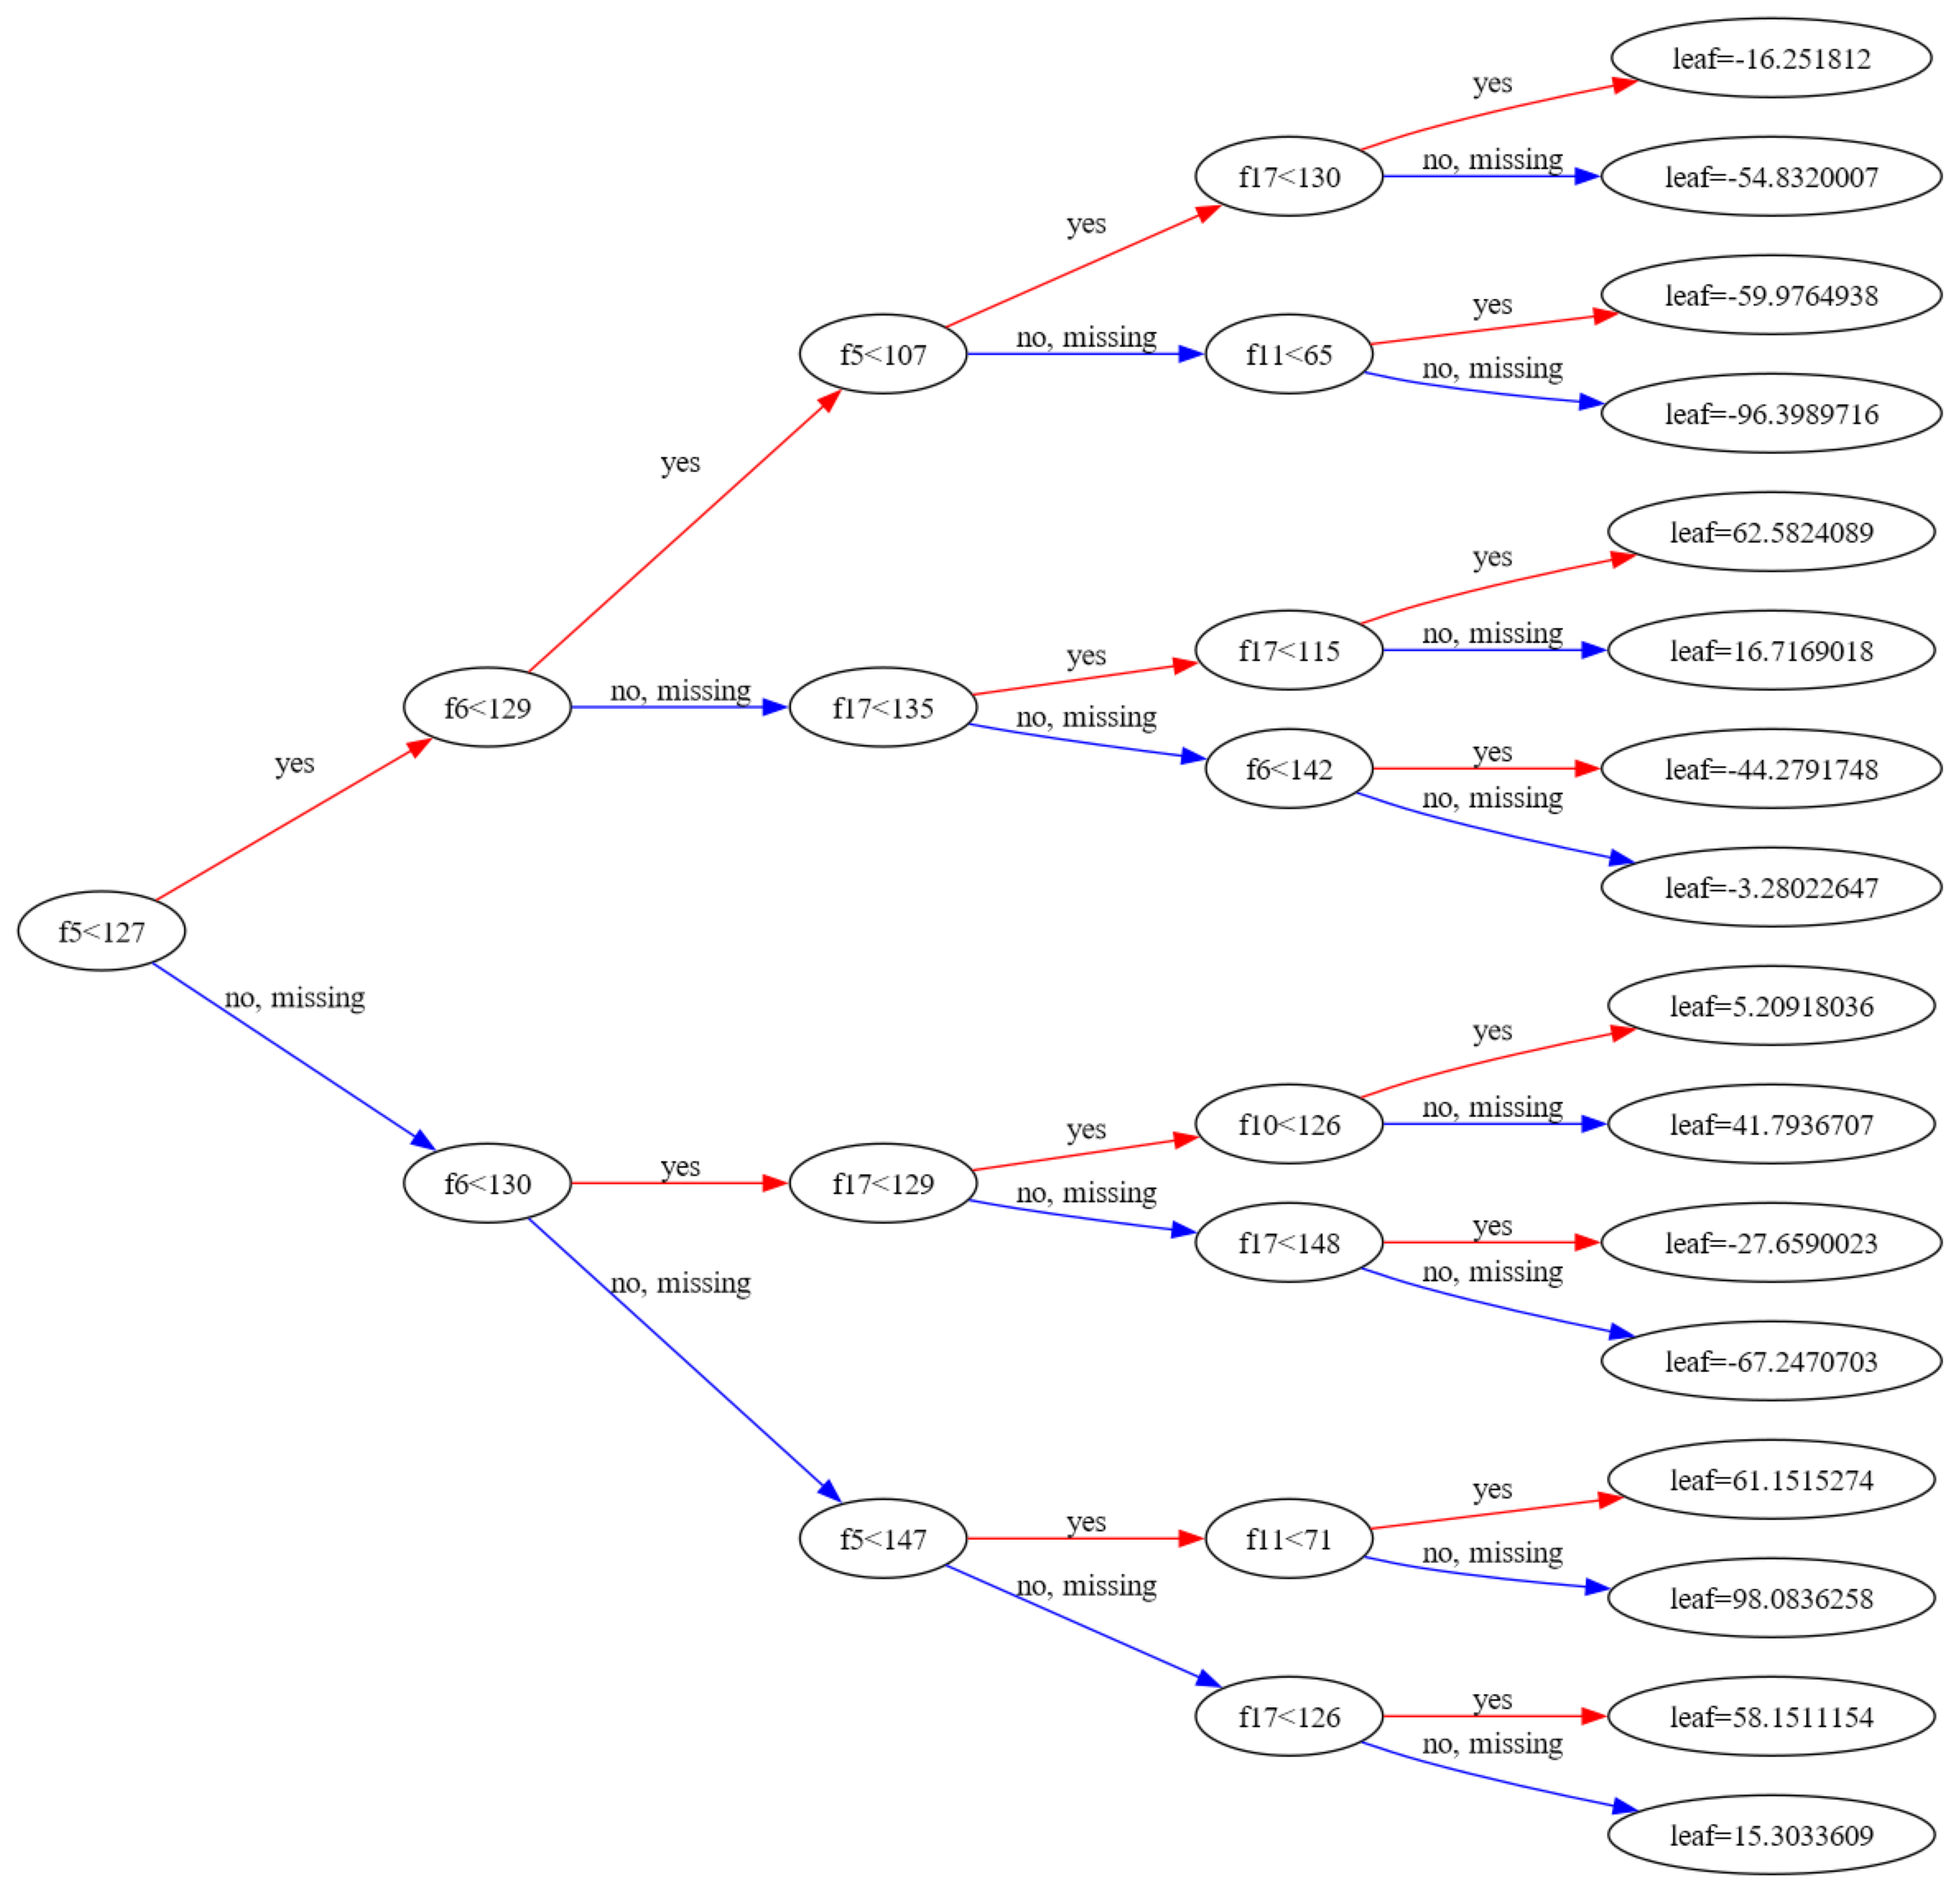

In [35]:
fig, ax = plt.subplots(figsize=(30, 20), dpi=150)
xgb.plot_tree(
    experiment.model, num_trees=0, ax=ax, rankdir="LR"
)  # LR for left to right direction
plt.tight_layout()
# plt.savefig("first_tree.png", dpi=500)
plt.show()

# Model Performance

In [36]:
mask_e = experiment.testing_dataset.physics_object_type == "electron"
mask_p = experiment.testing_dataset.physics_object_type == "photon"
mask_pi0 = experiment.testing_dataset.physics_object_type == "pi0"
mask_pi_char = experiment.testing_dataset.physics_object_type == "pi_char"

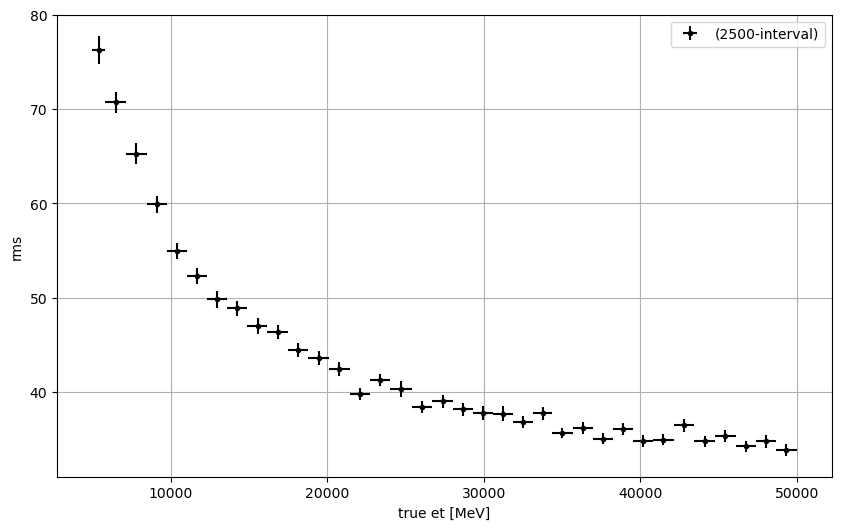

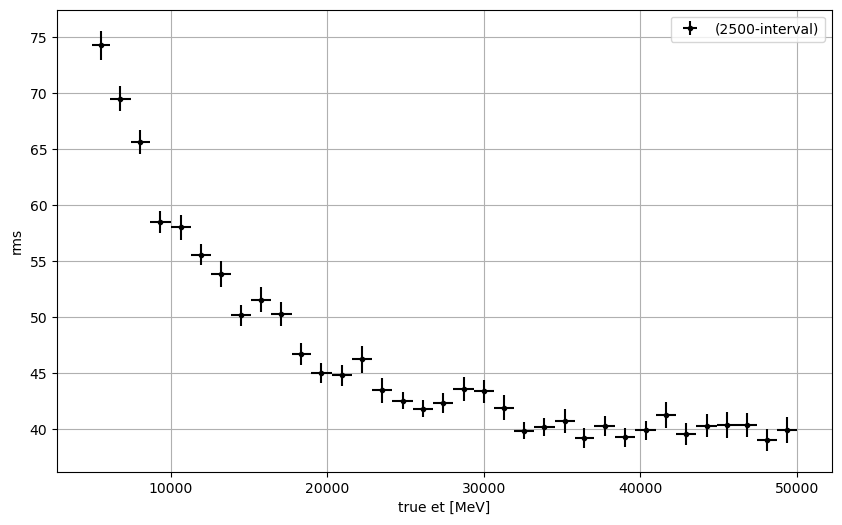

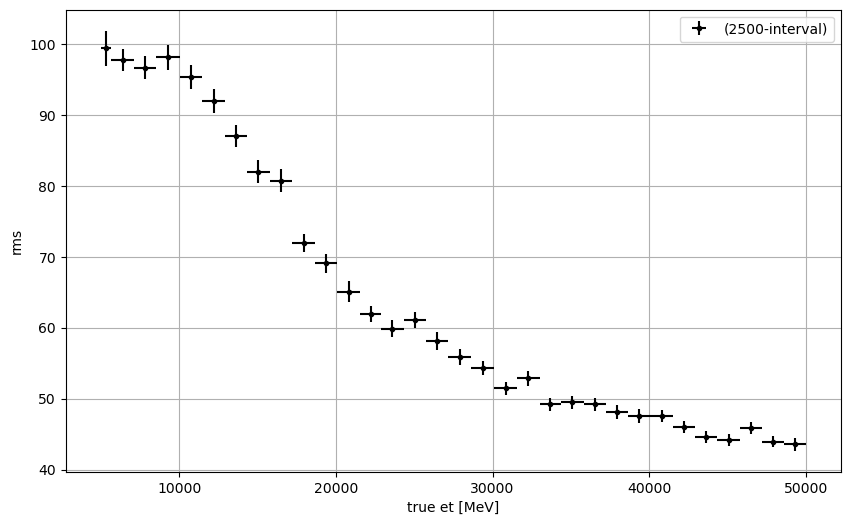

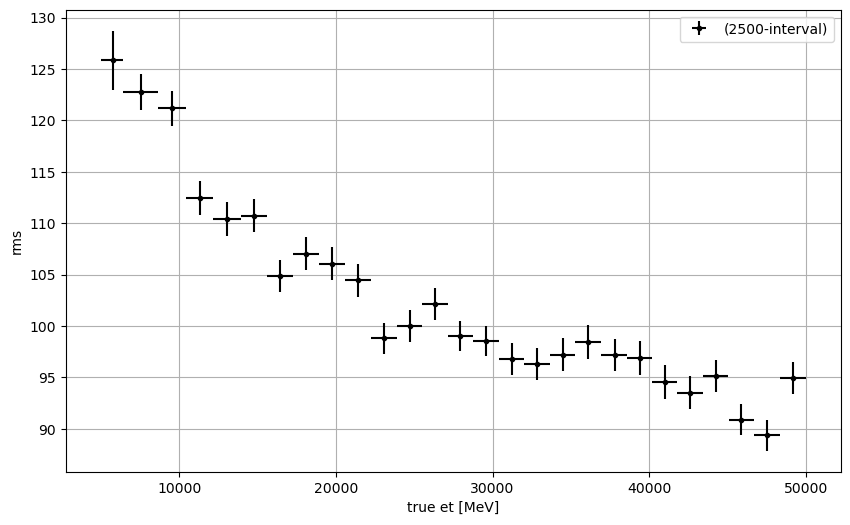

In [37]:
x_e, y_e, x_u_e, u_e = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_e],
    y_values=(experiment.y_test - experiment.y_pred)[mask_e],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
)

x_p, y_p, x_u_p, u_p = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_p],
    y_values=(experiment.y_test - experiment.y_pred)[mask_p],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
)

x_pi0, y_pi0, x_u_pi0, u_pi0 = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi0],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi0],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    ylabel="rms",
    return_values=True,
    return_x_u=True,
)

x_pi_char, y_pi_char, x_u_pi_char, u_pi_char = utils.plot_avg(
    x_values=experiment.testing_dataset["et"].values[mask_pi_char],
    y_values=(experiment.y_test - experiment.y_pred)[mask_pi_char],
    interval=2500,
    xlabel="true et [MeV]",
    rms=True,
    return_values=True,
    ylabel="rms",
    return_x_u=True,
)

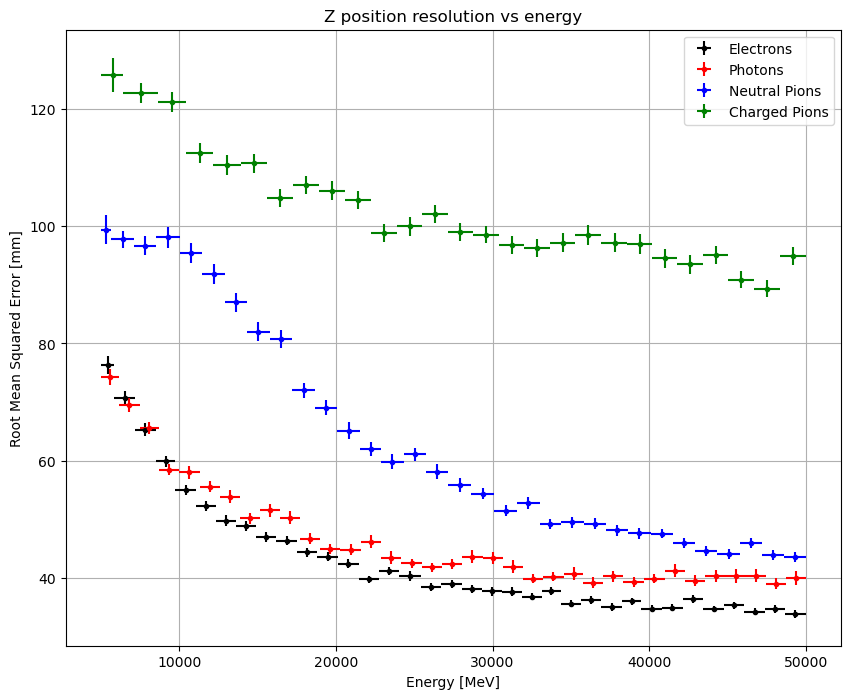

In [38]:
plt.figure(figsize=(10, 8))
plt.errorbar(x_e, y_e, xerr=x_u_e, yerr=u_e, fmt=".", label="Electrons", color="k")
plt.errorbar(x_p, y_p, xerr=x_u_p, yerr=u_p, fmt=".", label="Photons", color="r")
plt.errorbar(
    x_pi0, y_pi0, xerr=x_u_pi0, yerr=u_pi0, fmt=".", label="Neutral Pions", color="b"
)
plt.errorbar(
    x_pi_char,
    y_pi_char,
    xerr=x_u_pi_char,
    yerr=u_pi_char,
    fmt=".",
    label="Charged Pions",
    color="g",
)


# Adding labels and title
plt.xlabel("Energy [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Z position resolution vs energy")

plt.legend()
plt.grid()
plt.show()

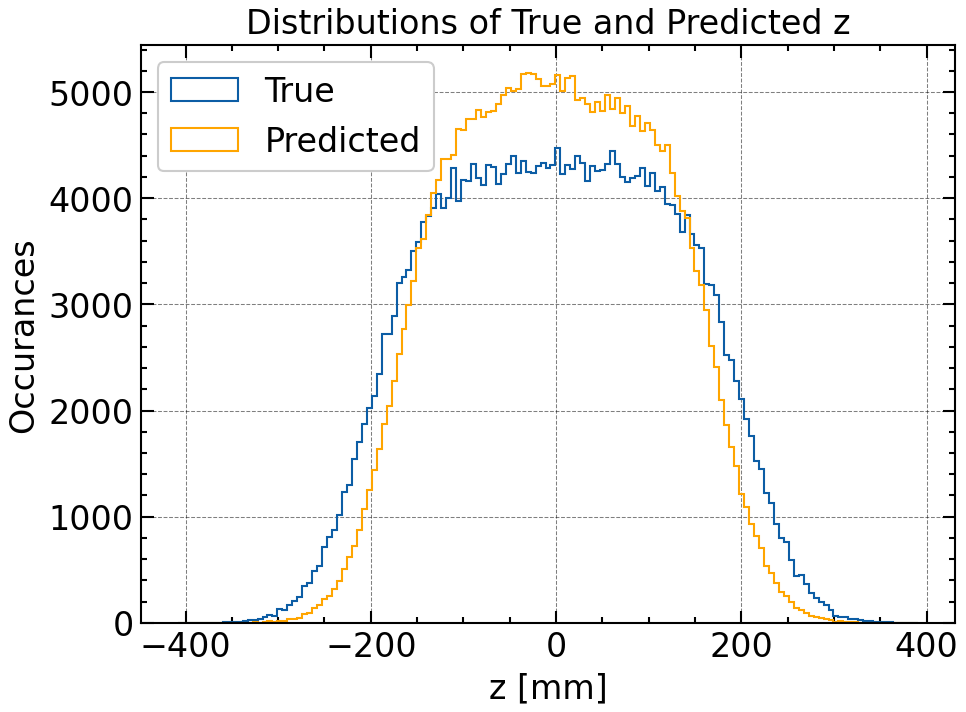

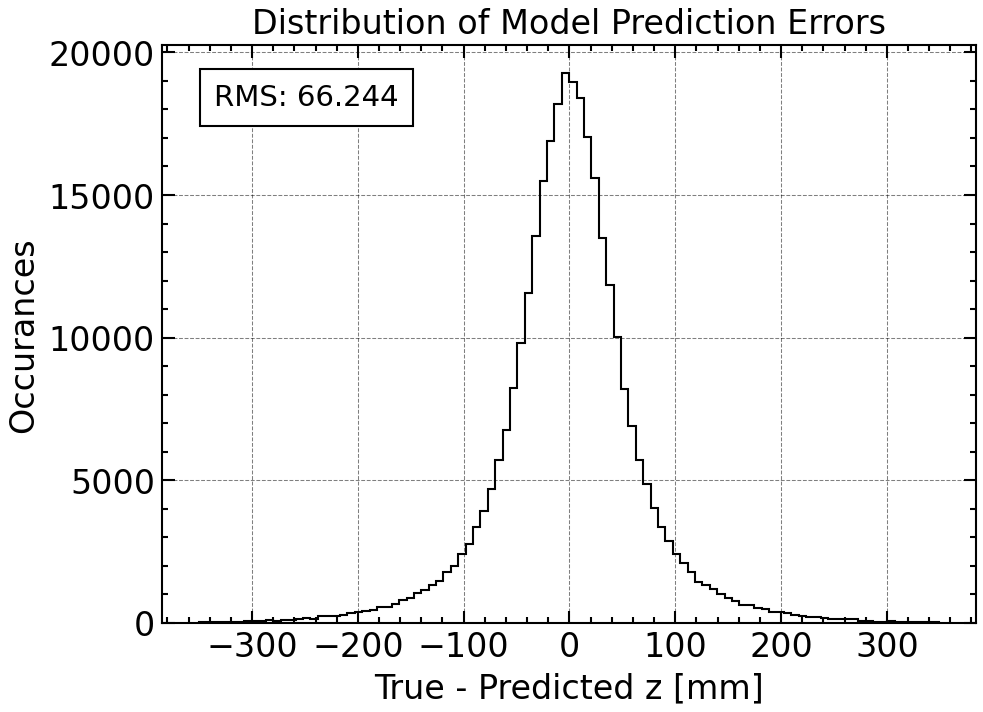

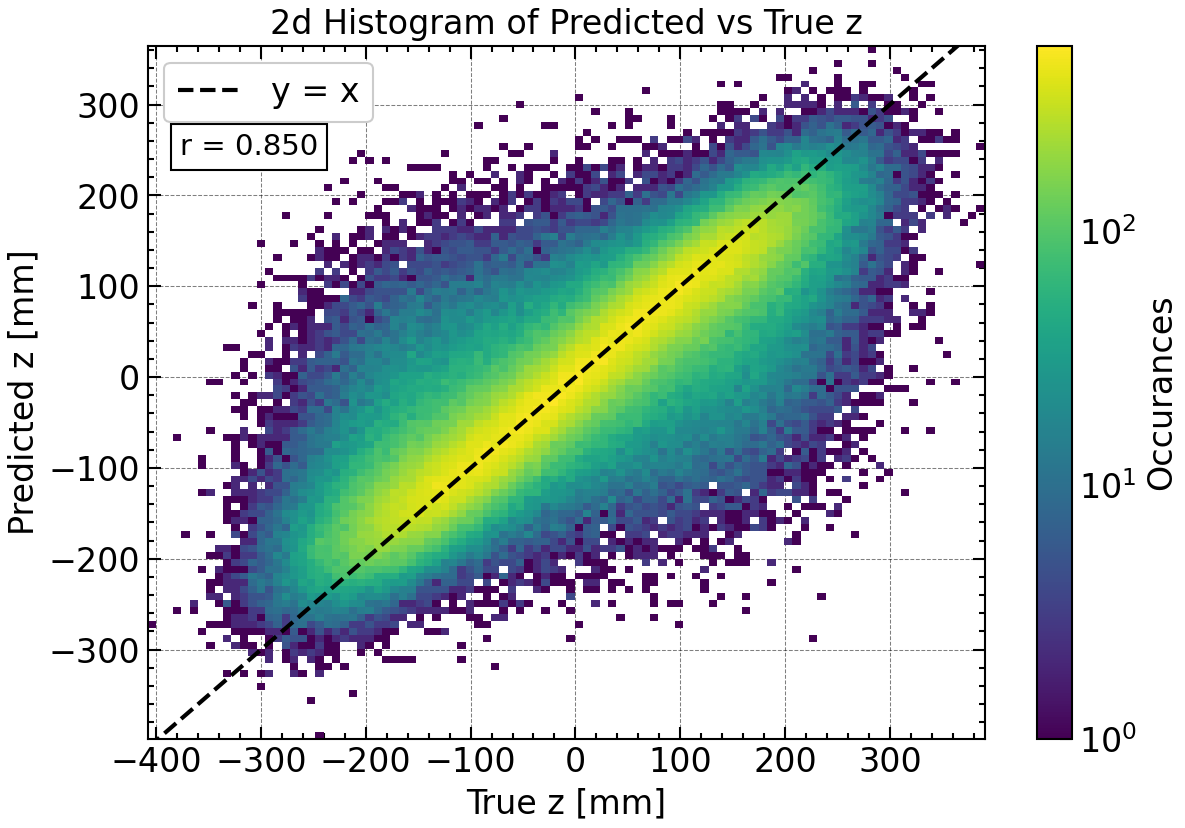

In [39]:
Y_test = experiment.y_test
Y_pred = experiment.y_pred
utils.plot_predictions(Y_test, Y_pred)

utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)

utils.plot_corelation(Y_test, Y_pred, density=True, log_density=True, plot_line=True)

In [40]:
experiment.X_train

array([[ 58, 462,  58, ..., 126,   0, 127],
       [ 78, 614,  77, ..., 131,   2, 128],
       [101, 811, 102, ..., 255,  29, 115],
       ...,
       [ 60, 481,  61, ..., 131,   2, 127],
       [ 41, 325,  41, ..., 132,   3, 127],
       [ 34, 269,  34, ..., 126,   4, 126]], dtype=int16)

In [41]:
np.sort(experiment.X_train.T[9])

array([  0,   0,   0, ..., 255, 255, 255], dtype=int16)

In [42]:
experiment.X_test

array([[109, 870, 109, ..., 123,   0, 128],
       [ 22, 184,  23, ..., 142,  19, 125],
       [ 69, 547,  69, ..., 127,   1, 128],
       ...,
       [  4,  31,   4, ..., 124,  25, 142],
       [ 64, 513,  65, ..., 136,   2, 128],
       [ 58, 462,  58, ..., 126,   0, 127]], dtype=int16)

In [43]:
experiment.y_train

array([ -45.1  ,  176.6  ,  -63.06 , ..., -177.5  ,  -94.7  ,   15.375],
      dtype=float16)

In [44]:
experiment.y_test

array([  -7.18, -184.5 ,  139.2 , ...,  199.4 ,  -69.44,  -45.1 ],
      dtype=float16)

# Shap for the Final Model

In [45]:
model = experiment.model
explainer = shap.TreeExplainer(model, check_additivity=False)

shap_values = explainer.shap_values(experiment.X_train, check_additivity=False)

[00:44:43] WARNING: D:\bld\xgboost-split_1705650032250\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


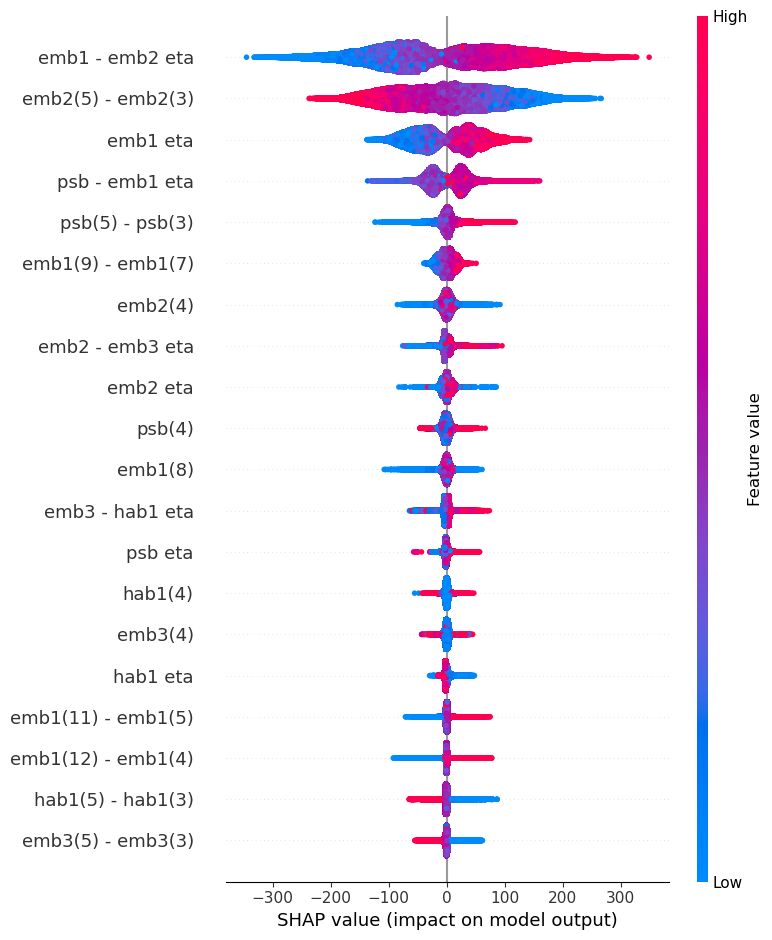

In [46]:
feature_names = [
    "psb eta",
    "emb1 eta",
    "emb2 eta",
    "emb3 eta",
    "hab1 eta",
    "psb - emb1 eta",
    "emb1 - emb2 eta",
    "emb2 - emb3 eta",
    "emb3 - hab1 eta",
    "psb(4)",
    "psb(5) - psb(3)",
    "emb1(8)",
    "emb1(9) - emb1(7)",
    "emb1(10) - emb1(6)",
    "emb1(11) - emb1(5)",
    "emb1(12) - emb1(4)",
    "emb2(4)",
    "emb2(5) - emb2(3)",
    "emb3(4)",
    "emb3(5) - emb3(3)",
    "hab1(4)",
    "hab1(5) - hab1(3)",
]


shap.summary_plot(shap_values, experiment.X_train, feature_names=feature_names)

In [47]:
x_plot1 = np.arange(-0.35, 0.35, 0.0001)

y_plot1 = np.array([q9.bin_function(val) for val in x_plot1])

Text(0.5, 1.0, ' Function quantising energy input (psb middle cell)')

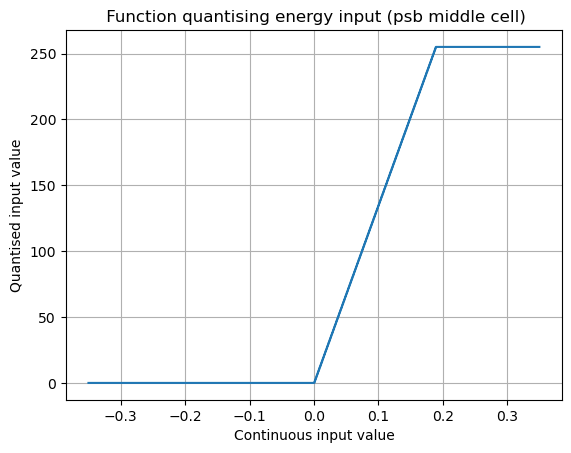

In [48]:
plt.plot(x_plot1, y_plot1)
plt.grid()
# plt.xlim(0, 0.05)
# plt.ylim(125, 160)
plt.xlabel("Continuous input value")
plt.ylabel("Quantised input value")
plt.title(" Function quantising energy input (psb middle cell)")

Text(0.5, 1.0, ' Function quantising energy input (psb middle cell)')

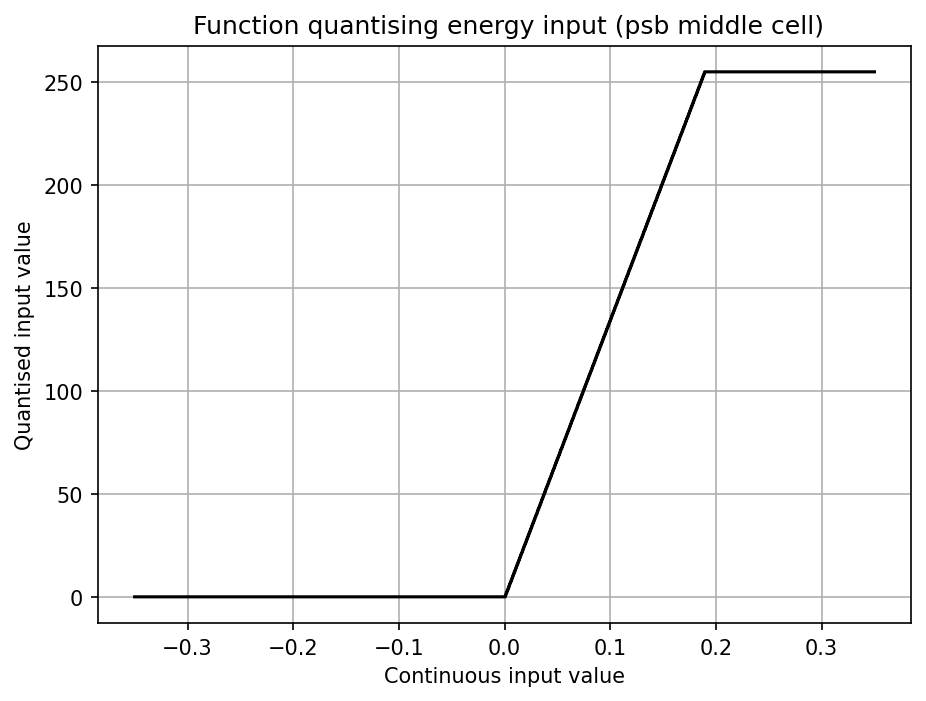

In [49]:
plt.figure(figsize=(7, 5), dpi=150)
plt.plot(x_plot1, y_plot1, color="k")
plt.grid()



plt.xlabel("Continuous input value")


plt.ylabel("Quantised input value")


plt.title(" Function quantising energy input (psb middle cell)")

Text(0.5, 1.0, 'Function quantising psb $\\eta$ - emb1 $\\eta$')

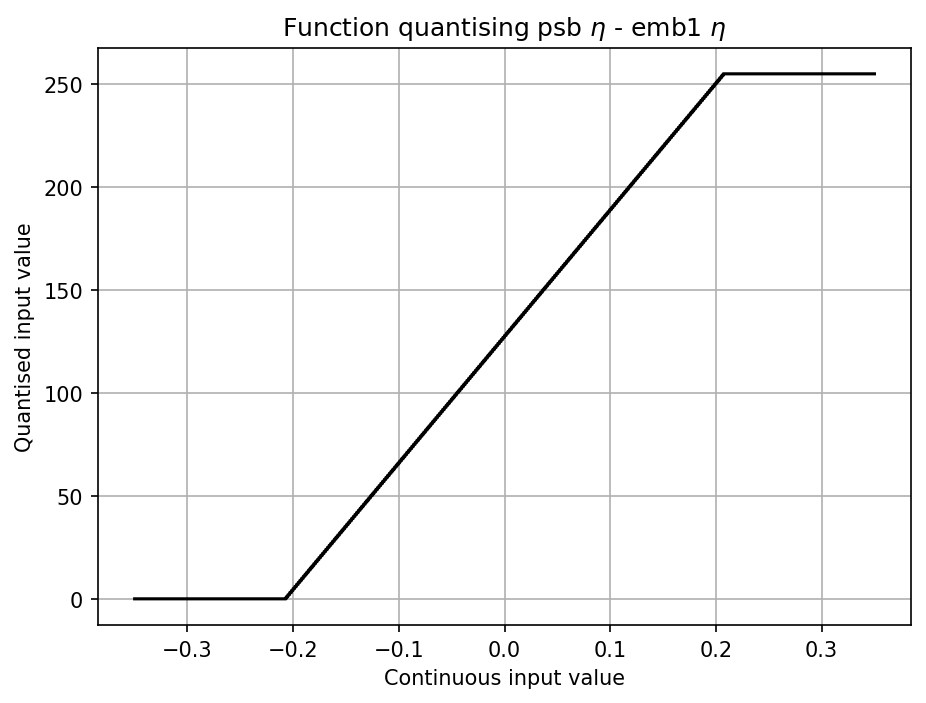

In [50]:
plt.figure(figsize=(7, 5), dpi=150)
x_plot1 = np.arange(-0.35, 0.35, 0.00001)



y_plot1 = np.array([diff1_q.bin_function(val) for val in x_plot1])



plt.plot(x_plot1, y_plot1, color="k")


plt.grid()


plt.xlabel("Continuous input value")


plt.ylabel("Quantised input value")



plt.title(r"Function quantising psb $\eta$ - emb1 $\eta$")

Text(0.5, 1.0, 'Function quantising psb $\\eta$ - emb1 $\\eta$ (not entire range)')

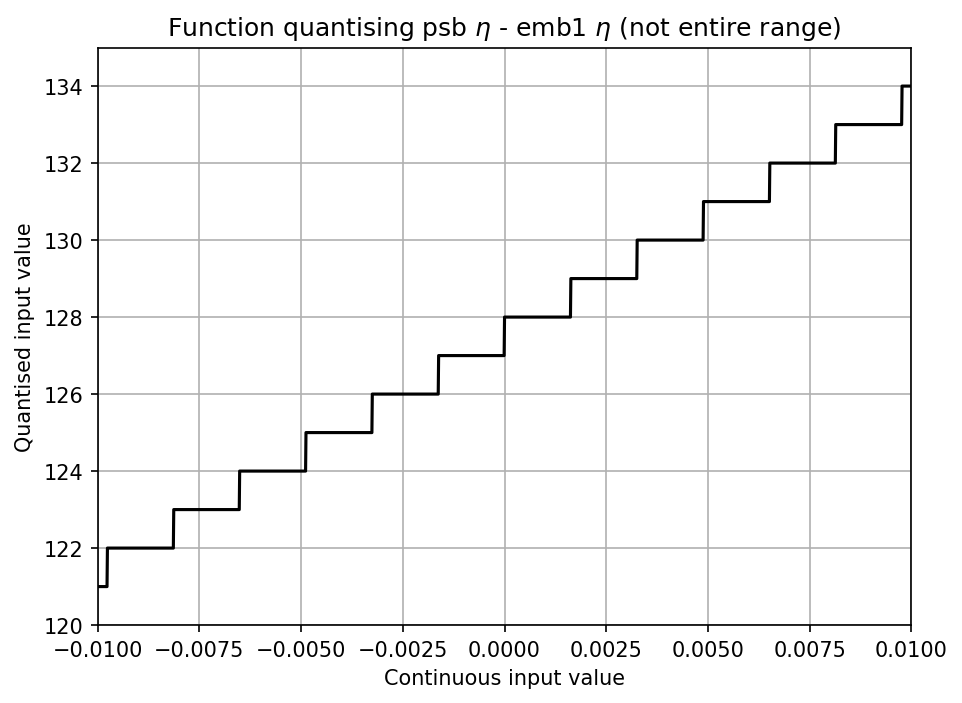

In [51]:
plt.figure(figsize=(7, 5), dpi=150)
plt.plot(x_plot1, y_plot1, color="k")


plt.grid()


plt.xlim(-0.01, 0.01)



plt.ylim(120, 135)


plt.xlabel("Continuous input value")


plt.ylabel("Quantised input value")



plt.title(r"Function quantising psb $\eta$ - emb1 $\eta$ (not entire range)")

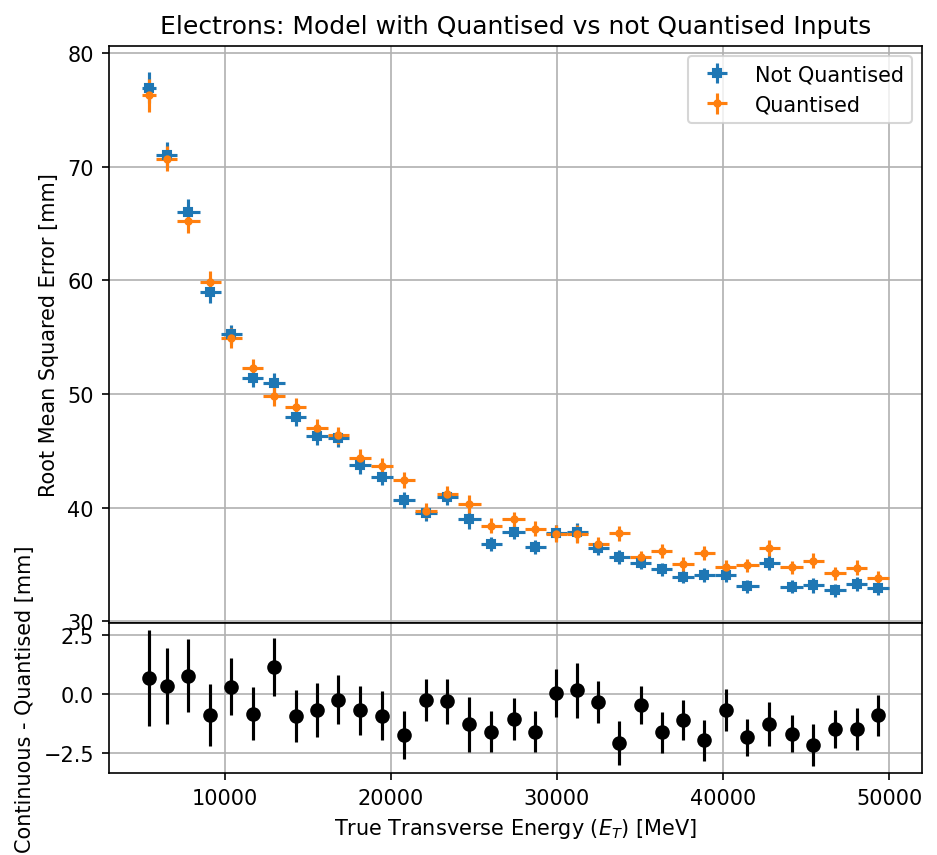

In [52]:
plt.figure(figsize=(7, 5), dpi=150)

# First plot
plt.errorbar(
    x_e1,
    y_e1,
    xerr=x_u_e1,
    yerr=u_e1,
    fmt="s",
    markersize=4,
    label="Not Quantised",
)

# Second plot
plt.errorbar(
    x_e,
    y_e,
    xerr=x_u_e,
    yerr=u_e,
    fmt=".",
    label="Quantised",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Electrons: Model with Quantised vs not Quantised Inputs")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_e1) - np.array(y_e)

# Plot the differences
plt.errorbar(
    x_e,
    differences,
    yerr=np.sqrt(u_e**2 + u_e1**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Continuous - Quantised [mm]")

plt.grid()
plt.show()

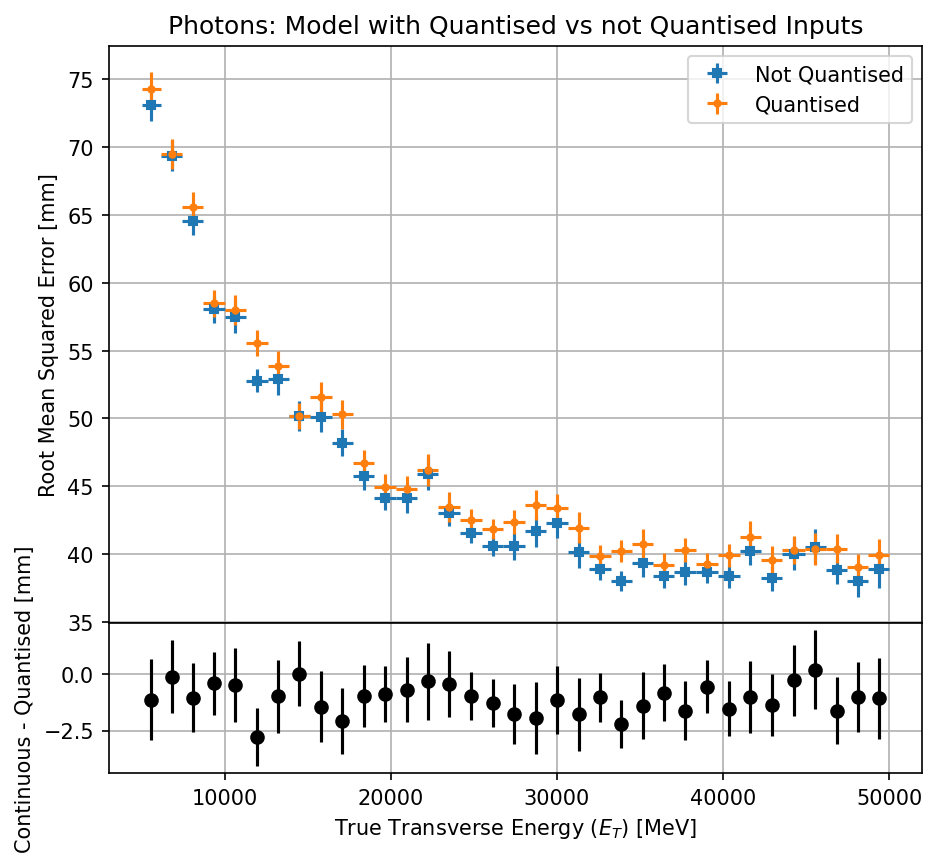

In [53]:
plt.figure(figsize=(7, 5), dpi=150)

# First plot
plt.errorbar(
    x_p1,
    y_p1,
    xerr=x_u_p1,
    yerr=u_p1,
    fmt="s",
    markersize=4,
    label="Not Quantised",
)

# Second plot
plt.errorbar(
    x_p,
    y_p,
    xerr=x_u_p,
    yerr=u_p,
    fmt=".",
    label="Quantised",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Photons: Model with Quantised vs not Quantised Inputs")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_p1) - np.array(y_p)

# Plot the differences
plt.errorbar(
    x_p,
    differences,
    yerr=np.sqrt(u_p**2 + u_p1**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Continuous - Quantised [mm]")

plt.grid()
plt.show()

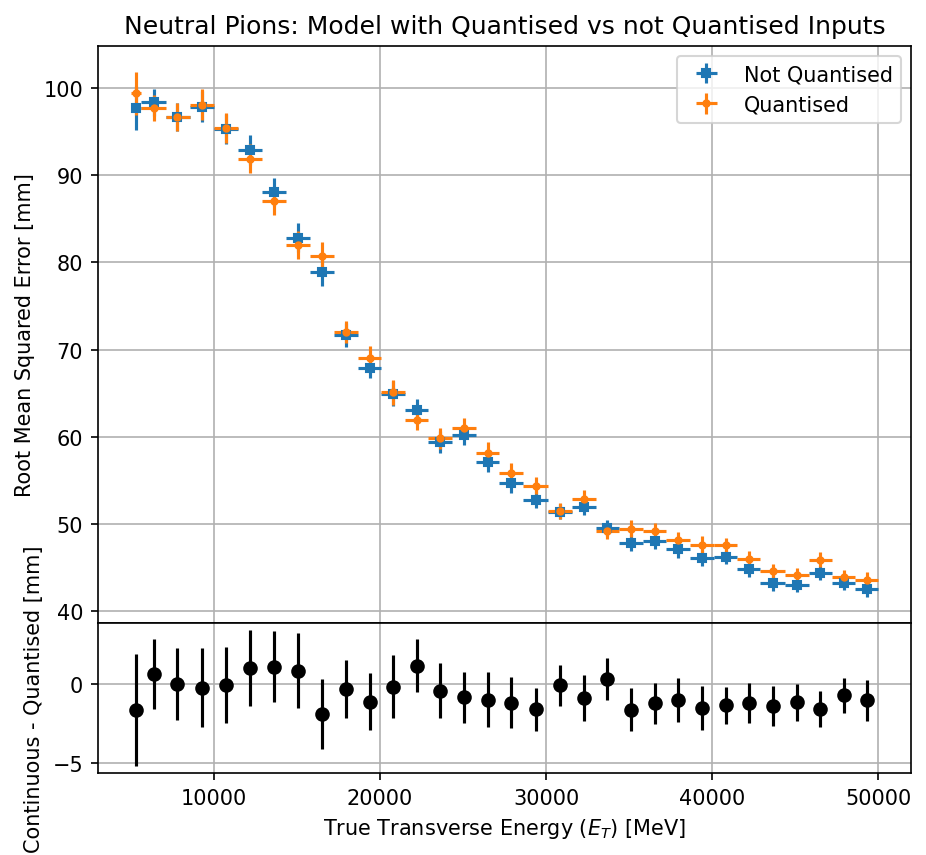

In [54]:
plt.figure(figsize=(7, 5), dpi=150)

# First plot
plt.errorbar(
    x_pi01,
    y_pi01,
    xerr=x_u_pi01,
    yerr=u_pi01,
    fmt="s",
    markersize=4,
    label="Not Quantised",
)

# Second plot
plt.errorbar(
    x_pi0,
    y_pi0,
    xerr=x_u_pi0,
    yerr=u_pi0,
    fmt=".",
    label="Quantised",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Neutral Pions: Model with Quantised vs not Quantised Inputs")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_pi01) - np.array(y_pi0)

# Plot the differences
plt.errorbar(
    x_pi0,
    differences,
    yerr=np.sqrt(u_pi0**2 + u_pi01**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Continuous - Quantised [mm]")

plt.grid()
plt.show()

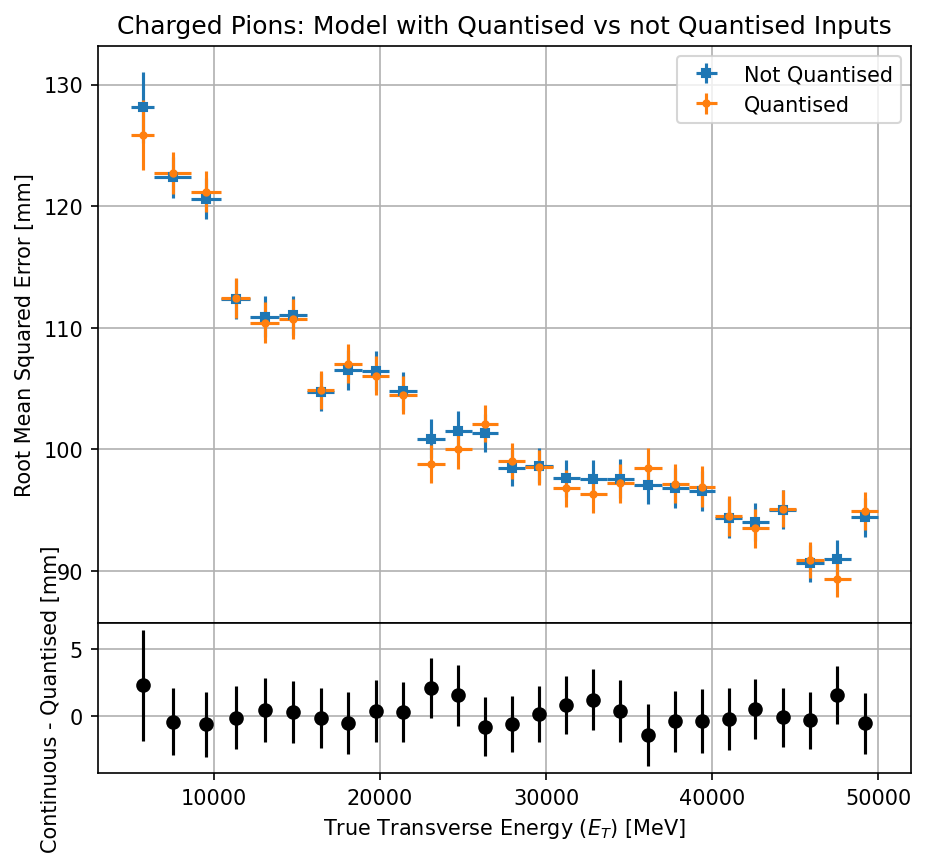

In [55]:
plt.figure(figsize=(7, 5), dpi=150)

# First plot
plt.errorbar(
    x_pi_char1,
    y_pi_char1,
    xerr=x_u_pi_char1,
    yerr=u_pi_char1,
    fmt="s",
    markersize=4,
    label="Not Quantised",
)

# Second plot
plt.errorbar(
    x_pi_char,
    y_pi_char,
    xerr=x_u_pi_char,
    yerr=u_pi_char,
    fmt=".",
    label="Quantised",
)

# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Root Mean Squared Error [mm]")
plt.title("Charged Pions: Model with Quantised vs not Quantised Inputs")
plt.xlim
plt.legend()
plt.grid()
plt.xlim(3000, 52000)
# Rectangular plot below the main plot
plt.axes([0.125, -0.09, 0.775, 0.2])  # left, bottom, width, height

# Calculate differences between the two plots vs x-axis
differences = np.array(y_pi_char1) - np.array(y_pi_char)

# Plot the differences
plt.errorbar(
    x_pi_char,
    differences,
    yerr=np.sqrt(u_pi_char**2 + u_pi_char1**2),
    fmt="o",
    color="k",
)
plt.xlim(3000, 52000)
# Adding labels and title
plt.xlabel(r"True Transverse Energy $(E_T)$ [MeV]")
plt.ylabel("Continuous - Quantised [mm]")

plt.grid()
plt.show()

# Hyperparams scan 

In [56]:
max_depth_range = [4]
learning_rate_range = [0.74]
subsample_range = [0.7, 0.8, 0.9, 1.0]
colsample_bytree_range = [0.7, 0.8, 0.9, 1.0]
num_rounds_grid = [130]

# Generate all combinations of hyperparameters
param_combinations = list(
    itertools.product(
        max_depth_range,
        learning_rate_range,
        subsample_range,
        colsample_bytree_range,
        num_rounds_grid,
    )
)

# Construct the param_grid
param_grid = [
    {
        "objective": "reg:squarederror",
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
    }
    for max_depth, learning_rate, subsample, colsample_bytree, n_estimators in param_combinations
]


# Perform hyperparameter scan
experiment_hyperparams = experiment.xgboost_hyperparameter_scan(
    param_grid, nodes_info=True, normalise=False
)

INFO: Trained XGBoost model; mean squared error: 4481.603515625
INFO: Trained XGBoost model; mean squared error: 4499.5322265625
INFO: Trained XGBoost model; mean squared error: 4467.42822265625
INFO: Trained XGBoost model; mean squared error: 4449.18408203125
INFO: Trained XGBoost model; mean squared error: 4466.76171875
INFO: Trained XGBoost model; mean squared error: 4485.65673828125
INFO: Trained XGBoost model; mean squared error: 4444.56787109375
INFO: Trained XGBoost model; mean squared error: 4397.48974609375
INFO: Trained XGBoost model; mean squared error: 4508.025390625
INFO: Trained XGBoost model; mean squared error: 4454.99072265625
INFO: Trained XGBoost model; mean squared error: 4436.7294921875
INFO: Trained XGBoost model; mean squared error: 4400.73974609375
INFO: Trained XGBoost model; mean squared error: 4480.95947265625
INFO: Trained XGBoost model; mean squared error: 4436.275390625
INFO: Trained XGBoost model; mean squared error: 4424.1435546875
INFO: Trained XGBoost 

In [57]:
experiment_hyperparams.sort_values(by="MSE")

,MSE,objective,max_depth,learning_rate,subsample,colsample_bytree,n_estimators,Nodes NO
7,4397.489746,reg:squarederror,4,0.74,0.8,1.0,130,1948
11,4400.739746,reg:squarederror,4,0.74,0.9,1.0,130,1949
14,4424.143555,reg:squarederror,4,0.74,1.0,0.9,130,1949
15,4431.531738,reg:squarederror,4,0.74,1.0,1.0,130,1948
13,4436.275391,reg:squarederror,4,0.74,1.0,0.8,130,1948
10,4436.729492,reg:squarederror,4,0.74,0.9,0.9,130,1950
6,4444.567871,reg:squarederror,4,0.74,0.8,0.9,130,1950
3,4449.184082,reg:squarederror,4,0.74,0.7,1.0,130,1947
9,4454.990723,reg:squarederror,4,0.74,0.9,0.8,130,1948
4,4466.761719,reg:squarederror,4,0.74,0.8,0.7,130,1944


In [58]:
utils.save_table_df(
    experiment_hyperparams.sort_values(by="MSE"), filename="11.0-quantised-hyperparams"
)

# Save the Model

In [59]:
params = {
    "objective": "reg:squarederror",
    "gamma": 100000,
    "max_depth": 4,
    "learning_rate": 0.74,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "eval_metric": "rmse",
    "n_estimators": 130,
}

experiment.train_xgboost_model(params, normalise=False)  # 4480.9043

INFO: Trained XGBoost model; mean squared error: 4388.322265625


4388.3223

In [60]:
# Define the path to save the model
current_directory = os.getcwd()
models_directory = os.path.join(current_directory, "..", "models")
filename = "model_1899_quantised_256.pkl"  # Save the model as a .pkl file
model_path = os.path.join(models_directory, filename)

# Ensure the directory exists
os.makedirs(models_directory, exist_ok=True)

# Save the model using pickle
with open(model_path, "wb") as f:
    pickle.dump(experiment.model, f)

In [61]:
current_directory = os.getcwd()
models_directory = os.path.join(current_directory, "..", "models")
filename = "model_1899_quantised_256.pkl"  # Ensure you saved the model as a .pkl file
model_path = os.path.join(models_directory, filename)

# Load the saved model
with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)

In [62]:
experiment.model = loaded_model
experiment.test_model()

INFO: y_pred length: 318433, model tested, MSE: 4388.322265625
